In [19]:
import numpy as np

from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

In [13]:
#load dataframe from csv
demographics_data = pd.read_csv("data/newdata/2018_demographic_data_edited.csv", delimiter=',')
print(demographics_data.shape)
del demographics_data["Geo_ZCTA5"]
del demographics_data["Geo_ZCTA3"]
del demographics_data["Geo_LOGRECNO"]
del demographics_data["Geo_GEOCOMP"]
del demographics_data["Geo_SUMLEV"]

(33120, 2151)


In [3]:
null_counts = demographics_data.isnull().sum()
print(null_counts[null_counts > 0])

SE_A01004_001      564
SE_A01004_002      843
SE_A01004_003      897
SE_A10003_001      726
SE_A10003B_001    2496
                  ... 
SE_A13007_009       35
SE_A13007_010       35
SE_A13007_011       35
SE_A10064_001       35
SE_A10064_002       35
Length: 870, dtype: int64


In [14]:
# drop any column with missing values greater than 5%
demographics_data.drop(columns=["SE_A18007_006","SE_A18007_007","SE_A18007_005","SE_A18007_004",
                     "SE_A18007_003","SE_A18007_002","SE_A18008_011",
                     "SE_A18008_010","SE_A18008_009","SE_A18010_002",
                     "SE_A18010_003","SE_A18010_004","SE_A18010_005",
                     "SE_A18010_006","SE_A18010_007","SE_A18008_001","SE_A18008_002",
                     "SE_A18008_003","SE_A18008_008","SE_A18008_007","SE_A18008_006","SE_A18008_005",
                     "SE_A18008_004"], axis=1, inplace=True)

In [6]:
reduced_demos = demographics_data[["SE_A00002_002", "SE_A14028_001", "SE_A14011_001", "SE_A14008_001", "SE_B10040_002", "SE_B10040_003"]]

In [9]:
null_counts = reduced_demos.isnull().sum()
print(null_counts[null_counts > 0])
reduced_demos = reduced_demos.dropna()
print(reduced_demos.shape)
reduced_demos = MinMaxScaler().fit_transform(reduced_demos)

Series([], dtype: int64)
(31458, 6)


What does MinMaxScaler Scaler do to our data?

In [10]:
print(reduced_demos[0:5])

[[0.00175629 0.59682726 0.02280502 0.01822725 0.07590909 0.05405405]
 [0.00822887 0.57285546 0.03541307 0.03041038 0.17443182 0.13534145]
 [0.01011993 0.64712103 0.04198879 0.03651661 0.22363636 0.1689705 ]
 [0.0009972  0.54747356 0.01878494 0.01330712 0.02806818 0.04085001]
 [0.00494126 0.53231492 0.03997374 0.03416964 0.12943182 0.09531669]]


Let's see if we can just hack finding the best params for DBSCAN

 For epsilon   0.01  and samples  5  we get clusters:  0  and noise points:  31458
 For epsilon   0.1  and samples  5  we get clusters:  112  and noise points:  20884
 For epsilon   0.5  and samples  5  we get clusters:  26  and noise points:  2335
 For epsilon   1.0  and samples  5  we get clusters:  3  and noise points:  440
 For epsilon   2.0  and samples  5  we get clusters:  2  and noise points:  67
 For epsilon   10.0  and samples  5  we get clusters:  1  and noise points:  0
 For epsilon   0.01  and samples  10  we get clusters:  0  and noise points:  31458
 For epsilon   0.1  and samples  10  we get clusters:  28  and noise points:  24111
 For epsilon   0.5  and samples  10  we get clusters:  5  and noise points:  3140
 For epsilon   1.0  and samples  10  we get clusters:  2  and noise points:  591
 For epsilon   2.0  and samples  10  we get clusters:  3  and noise points:  138
 For epsilon   10.0  and samples  10  we get clusters:  1  and noise points:  0
 For epsilon   0.01  

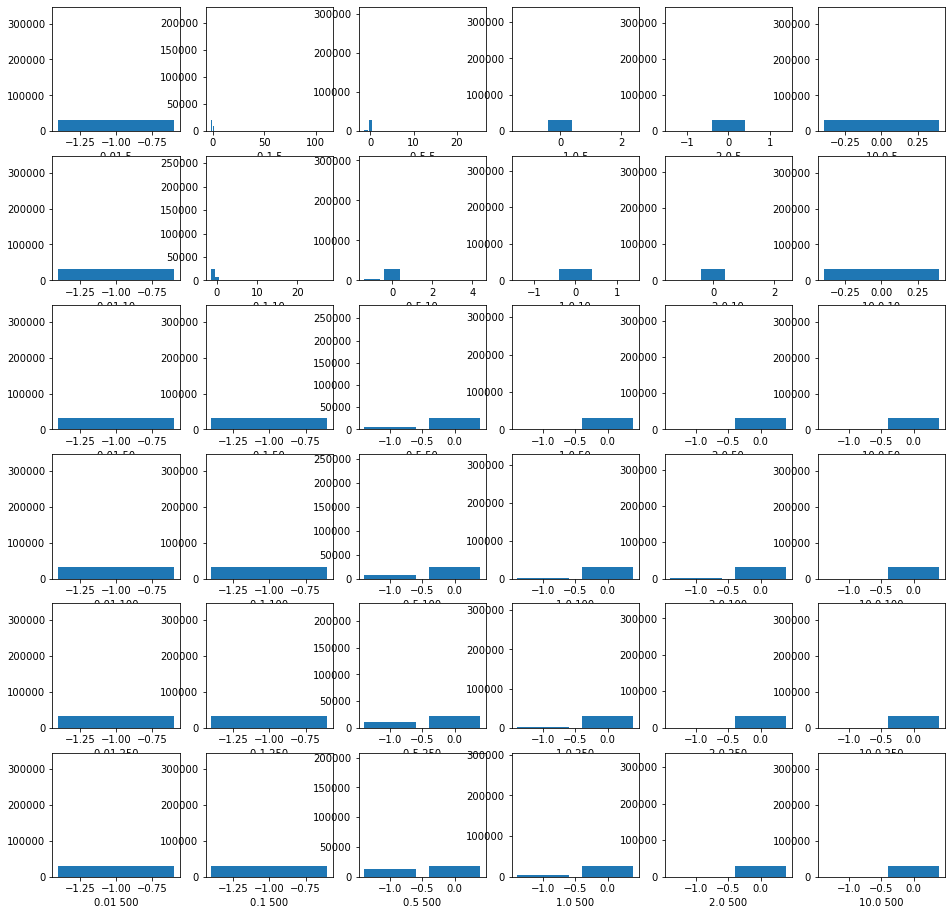

In [56]:

eps = [0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
samples = [5, 10, 50, 100, 250, 500]

fig, axes = plt.subplots(6, 6, figsize = (16, 16))

for i, ax in enumerate(axes.reshape(-1)):
    s = samples[int(i/6)]
    e = eps[int(i % 6)]
    # define the model
    dbscan_model = DBSCAN(eps=e, min_samples=s)

    # train the model
    dbscan_model.fit(reduced_demos)

    core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)
    core_samples_mask[dbscan_model.core_sample_indices_] = True
    labels = dbscan_model.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print(" For epsilon  ", e, " and samples ", s, " we get clusters: ", n_clusters_, " and noise points: ", n_noise_)

    clusters = np.unique(labels, return_counts=True)
    ax.bar(clusters[0],clusters[1])
    ax.set_xlabel(str(e) + " " + str(s))
    ax.set_ymargin(10)

# plt.tightlayout()
plt.show()

How does our best DBSCAN approach look?

In [13]:
dbscan_model_refined = DBSCAN(eps=0.5, min_samples=5)

# train the model
dbscan_model_refined.fit(reduced_demos)

core_samples_mask = np.zeros_like(dbscan_model_refined.labels_, dtype=bool)
core_samples_mask[dbscan_model_refined.core_sample_indices_] = True
labels = dbscan_model_refined.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(" FOR EPS : ", e, " AND SAMPLES ", s)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

unique_labels = set(labels)
for k in unique_labels:
    class_member_mask = (labels == k)
    xy = reduced_demos[class_member_mask & core_samples_mask]
    print("number of members in cluster ", k, ": ", len(xy))

 FOR EPS :  1.0  AND SAMPLES  5
Estimated number of clusters: 26
Estimated number of noise points: 2335
number of members in cluster  0 :  28271
number of members in cluster  1 :  5
number of members in cluster  2 :  4
number of members in cluster  3 :  2
number of members in cluster  4 :  2
number of members in cluster  5 :  2
number of members in cluster  6 :  1
number of members in cluster  7 :  3
number of members in cluster  8 :  1
number of members in cluster  9 :  5
number of members in cluster  10 :  2
number of members in cluster  11 :  2
number of members in cluster  12 :  8
number of members in cluster  13 :  2
number of members in cluster  14 :  2
number of members in cluster  15 :  1
number of members in cluster  16 :  1
number of members in cluster  17 :  1
number of members in cluster  18 :  1
number of members in cluster  19 :  1
number of members in cluster  20 :  1
number of members in cluster  21 :  1
number of members in cluster  22 :  3
number of members in cluster

In [22]:
demographics_data = demographics_data.fillna(demographics_data.mean())
#reduced_all = StandardScaler().fit_transform(demographics_data)

# make sure we don't have the zip codes in our data
# but do make sure we can use them later, so split the data set
demographics_data_zip_codes = demographics_data["zip"]
demographics_data_no_zip = demographics_data.drop("zip", axis=1)

# scale all our values except Zip Code down:
scaler = MinMaxScaler()
scaled_all = scaler.fit_transform(demographics_data_no_zip)
print(scaled_all.shape)
print(scaled_all[0:5])


(33120, 2122)
[[0.14039116 0.14039116 0.00097285 ... 0.04167478 0.01794072 0.00612089]
 [0.31300992 0.31300992 0.00455805 ... 0.11450828 0.06357254 0.00841622]
 [0.39746283 0.39746283 0.00560552 ... 0.21129503 0.04602184 0.013772  ]
 [0.05241259 0.05241259 0.00055238 ... 0.02336904 0.0074103  0.00420811]
 [0.22043904 0.22043904 0.00273702 ... 0.0946446  0.02145086 0.00612089]]


Trying DBSCAN on all the data to see if it gives better results

Running a DBSCAN on all the data takes about 3 hours :/

In [38]:

dbscan_model_all = DBSCAN(eps=10.0, min_samples=2)

# train the model
dbscan_model_all.fit(scaled_all)

# now check our clusters
core_samples_mask = np.zeros_like(dbscan_model_all.labels_, dtype=bool)
core_samples_mask[dbscan_model_all.core_sample_indices_] = True
labels = dbscan_model_all.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# print(" FOR EPS : ", e, " AND SAMPLES ", s)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

unique_labels = set(labels)
for k in unique_labels:
    class_member_mask = (labels == k)
    xy = scaled_all[class_member_mask & core_samples_mask]
    print("number of members in cluster ", k, ": ", len(xy))

Estimated number of clusters: 37
Estimated number of noise points: 14367
number of members in cluster  0 :  18674
number of members in cluster  1 :  2
number of members in cluster  2 :  2
number of members in cluster  3 :  2
number of members in cluster  4 :  3
number of members in cluster  5 :  2
number of members in cluster  6 :  2
number of members in cluster  7 :  3
number of members in cluster  8 :  2
number of members in cluster  9 :  2
number of members in cluster  10 :  2
number of members in cluster  11 :  2
number of members in cluster  12 :  2
number of members in cluster  13 :  2
number of members in cluster  14 :  2
number of members in cluster  15 :  2
number of members in cluster  16 :  2
number of members in cluster  17 :  3
number of members in cluster  18 :  2
number of members in cluster  19 :  4
number of members in cluster  20 :  2
number of members in cluster  21 :  2
number of members in cluster  22 :  2
number of members in cluster  23 :  2
number of members in 

Maybe we can reduce the dimenssions with PCA first and then run it?

In [24]:
from sklearn.decomposition import PCA

#run PCA with 20 components, the first captures 77% of the variance, which seems weird
pca = PCA(n_components=20)

scaled_all_pca = pca.fit_transform(scaled_all)

print(pca.explained_variance_ratio_)
print(" percent of variance captured:: ", np.sum(pca.explained_variance_ratio_))

[0.77448479 0.0501509  0.02451345 0.01979966 0.01013345 0.00852363
 0.00579488 0.00533748 0.00478141 0.00378477 0.00352103 0.00322128
 0.00278521 0.00270193 0.00234898 0.00212586 0.00200442 0.00193203
 0.00179749 0.00154444]
 percent of variance captured::  0.9312871191639139


 For epsilon   0.1  and samples  3  we get clusters:  232  and noise points:  29294
 For epsilon   0.2  and samples  3  we get clusters:  87  and noise points:  15657
 For epsilon   0.5  and samples  3  we get clusters:  88  and noise points:  6954
 For epsilon   0.75  and samples  3  we get clusters:  73  and noise points:  3917
 For epsilon   1.0  and samples  3  we get clusters:  50  and noise points:  2109
 For epsilon   2.0  and samples  3  we get clusters:  15  and noise points:  260
 For epsilon   0.1  and samples  5  we get clusters:  53  and noise points:  30385
 For epsilon   0.2  and samples  5  we get clusters:  23  and noise points:  16485
 For epsilon   0.5  and samples  5  we get clusters:  20  and noise points:  7454
 For epsilon   0.75  and samples  5  we get clusters:  24  and noise points:  4381
 For epsilon   1.0  and samples  5  we get clusters:  12  and noise points:  2495
 For epsilon   2.0  and samples  5  we get clusters:  7  and noise points:  335
 For epsilon

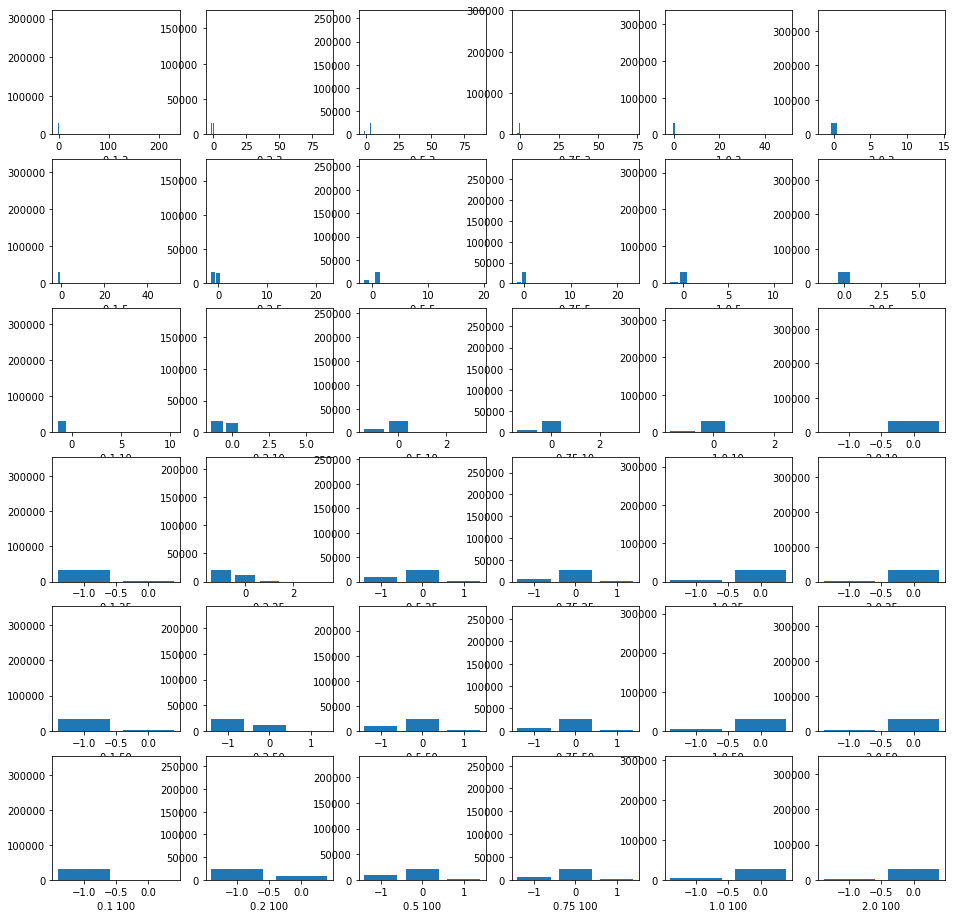

In [20]:

eps = [0.1, 0.2, 0.5, 0.75, 1.0, 2.0, 4.0]
samples = [3, 5, 10, 25, 50, 100]

fig, axes = plt.subplots(6, 6, figsize = (16, 16))

for i, ax in enumerate(axes.reshape(-1)):
    s = samples[int(i/6)]
    e = eps[int(i % 6)]
    # define the model
    dbscan_model = DBSCAN(eps=e, min_samples=s)

    # train the model
    dbscan_model.fit(reduced_all_pca)

    core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)
    core_samples_mask[dbscan_model.core_sample_indices_] = True
    labels = dbscan_model.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print(" For epsilon  ", e, " and samples ", s, " we get clusters: ", n_clusters_, " and noise points: ", n_noise_)

    clusters = np.unique(labels, return_counts=True)
    ax.bar(clusters[0],clusters[1])
    ax.set_xlabel(str(e) + " " + str(s))
    ax.set_ymargin(10)

plt.show()

In [25]:
dbscan_model_new = DBSCAN(eps=0.75, min_samples=5)

# train the model
dbscan_model_new.fit(scaled_all_pca)

core_samples_mask = np.zeros_like(dbscan_model_new.labels_, dtype=bool)
core_samples_mask[dbscan_model_new.core_sample_indices_] = True
labels = dbscan_model_new.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

unique_labels = set(labels)
for k in unique_labels:
    class_member_mask = (labels == k)
    xy = scaled_all_pca[class_member_mask & core_samples_mask]
    print("number of members in cluster ", k, ": ", len(xy))

Estimated number of clusters: 24
Estimated number of noise points: 4381
number of members in cluster  0 :  26441
number of members in cluster  1 :  1
number of members in cluster  2 :  1
number of members in cluster  3 :  1
number of members in cluster  4 :  1499
number of members in cluster  5 :  1
number of members in cluster  6 :  1
number of members in cluster  7 :  3
number of members in cluster  8 :  2
number of members in cluster  9 :  2
number of members in cluster  10 :  3
number of members in cluster  11 :  1
number of members in cluster  12 :  1
number of members in cluster  13 :  1
number of members in cluster  14 :  1
number of members in cluster  15 :  1
number of members in cluster  16 :  1
number of members in cluster  17 :  1
number of members in cluster  18 :  1
number of members in cluster  19 :  1
number of members in cluster  20 :  1
number of members in cluster  21 :  1
number of members in cluster  22 :  1
number of members in cluster  23 :  2
number of members i

Peter suggested trying HDBScan, which is a variation on DBSCAN https://hdbscan.readthedocs.io/ 
    
We use it in the same way as DBSCAN so first we can try it on our non-PCA'd data:

In [ ]:
import hdbscan

cluster_sizes = [3, 5, 10, 25, 50]

for cs in cluster_sizes:
    
    print("with cluster_size ", cs)

    clusterer = hdbscan.HDBSCAN(min_cluster_size=cs, min_samples=3)
    clusterer.fit(scaled_all)

    labels = clusterer.labels_

    unique_labels = set(labels)
    for k in unique_labels:
        class_member_mask = (labels == k)
        xy = scaled_all[class_member_mask & core_samples_mask]
        print("number of members in cluster ", k, ": ", len(xy))
    
    print(" ---------------------------------------------------- ")

with cluster_size  3
number of members in cluster  0 :  0
number of members in cluster  1 :  0
number of members in cluster  2 :  0
number of members in cluster  3 :  0
number of members in cluster  4 :  0
number of members in cluster  5 :  0
number of members in cluster  6 :  0
number of members in cluster  7 :  0
number of members in cluster  8 :  0
number of members in cluster  9 :  0
number of members in cluster  10 :  0
number of members in cluster  11 :  0
number of members in cluster  12 :  0
number of members in cluster  13 :  0
number of members in cluster  14 :  0
number of members in cluster  15 :  0
number of members in cluster  16 :  0
number of members in cluster  17 :  0
number of members in cluster  18 :  0
number of members in cluster  19 :  0
number of members in cluster  20 :  0
number of members in cluster  21 :  0
number of members in cluster  22 :  0
number of members in cluster  23 :  0
number of members in cluster  24 :  0
number of members in cluster  25 :  0
n

number of members in cluster  -1 :  24973
 ---------------------------------------------------- 
with cluster_size  5


Now let's see how it does on the data that's been reduced using PCA

In [ ]:
import hdbscan

cluster_sizes = [3, 5, 10, 25, 50]

for cs in cluster_sizes:
    
    print("with cluster_size ", cs)

    clusterer = hdbscan.HDBSCAN(min_cluster_size=cs, min_samples=3)
    clusterer.fit(scaled_all_pca)

    labels = clusterer.labels_

    unique_labels = set(labels)
    for k in unique_labels:
        class_member_mask = (labels == k)
        xy = scaled_all_pca[class_member_mask & core_samples_mask]
        print("number of members in cluster ", k, ": ", len(xy))
    
    print(" ---------------------------------------------------- ")